In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from matplotlib.colors import LogNorm

In [2]:
dbFile = 'feature_baseline_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.Database(dbFile, defaultTable='observations')
outDir='temp'

In [3]:
def survey_perf(conn, mjdCol='mjd', latCol = 'dec', lonCol = 'RA', expTimeCol='exptime',
                dec1=-20., dec2=-1, ra1=300, ra2=360, outDir='temp', degrees=True, filtername="g",
               altCol='altitude' , azCol='azimuth', runName=''):
    
    if not degrees:
        dec1 = np.radians(dec1)
        dec2 = np.radians(dec2)
        ra1=np.radians(ra1)
        ra2 = np.radians(ra2)
    
    resultsDb = db.ResultsDb(outDir=outDir)
    bundleList = []

    metric = metrics.BruteOSFMetric(expTimeCol=expTimeCol, mjdCol=mjdCol)
    slicer = slicers.UniSlicer()
    sql = ''
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

    sql='%s > %f and %s < %f and %s > %f and %s < %f and filter="%s"' %  (latCol, dec1, latCol, dec2, 
                                                                          lonCol, ra1, lonCol, ra2,
                                                                          filtername)
    # Let's check the median airmass and number of observations
    metric = metrics.MedianMetric(col='airmass')
    slicer = slicers.UniSlicer()
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))
    
    metric = metrics.CountMetric(col=mjdCol)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

    metric = metrics.CountMetric(col=mjdCol)
    slicer=slicers.HealpixSlicer(latCol=latCol, lonCol=lonCol, latLonDeg=degrees)
    ss = metrics.MedianMetric()
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, summaryMetrics=ss, stackerList=[]))
    
    # Plot all the observations
    slicer = slicers.HealpixSlicer(nside=64, latCol=altCol, lonCol=azCol,
                                   latLonDeg=degrees, useCache=False)
    metric = metrics.CountMetric(mjdCol, metricName='Observation Density')
    plotFunc = plots.LambertSkyMap()
    #min_log = np.log10(1.)
    #max_log = np.log10(50000.)
    #step = (max_log-min_log)/200.
    #log_levels = np.arange(min_log, max_log+step, step)
    #levels = 10.**log_levels
    #levels = np.logspace(0,np.log10(50000), 200)
    levels = 200
    levels = np.arange(0, 50000, 250)
    levels[0] = 1
    plotDict = {'norm': LogNorm(), 'levels': levels, 'cmap': 'jet', 'xlabel': '# Observations'}
    sql=''
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotFuncs=[plotFunc], plotDict=plotDict))
    
    for bun in bundleList:
        bun.setRunName(runName)
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll()
    print('Open Shutter Fraction=%f' % bundleList[0].metricValues.data)
    print('Median airmass = %f' % bundleList[1].metricValues.data)
    print('Counts in sub area= %i' % bundleList[2].metricValues.data)
    print('Median Count = %f' % bundleList[3].summaryValues['Median'])
    print('Median Count / N obs = %f' % (bundleList[3].summaryValues['Median']/bundleList[2].metricValues.data))
    return bundleList


In [4]:
bl = survey_perf(conn, outDir='FB', altCol='alt', azCol='az', runName='FB')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['az', 'alt', 'mjd', 'exptime'].
Found 2304791 visits
Running:  ['FB_BruteOSFMetric_UNIS']
Completed metric generation.
Running:  ['FB_Observation_Density_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint dec > -20.000000 and dec < -1.000000 and RA > 300.000000 and RA < 360.000000 and filter="g" for columns ['airmass', 'mjd', 'RA', 'dec']
Found 12209 visits
Running:  ['FB_Median_airmass_dec_gt_-20_000000_and_dec_lt_-1_000000_and_RA_gt_300_000000_and_RA_lt_360_000000_and_g_UNIS', 'FB_Count_mjd_dec_gt_-20_000000_and_dec_lt_-1_000000_and_RA_gt_300_000000_and_RA_lt_360_000000_and_g_UNIS']
Completed metric generation.
Running:  ['FB_Count_mjd_dec_gt_-20_000000_and_dec_lt_-1_000000_and_RA

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Plotting complete.
Plotting figures with "dec > -20.000000 and dec < -1.000000 and RA > 300.000000 and RA < 360.000000 and filter="g"" constraint now.
monopole: -159.637  dipole: lon: -31.0243, lat: -9.54311, amp: 260.361
Plotting complete.
Open Shutter Fraction=0.705491
Median airmass = 1.097497
Counts in sub area= 12209
Median Count = 99.000000
Median Count / N obs = 0.008109


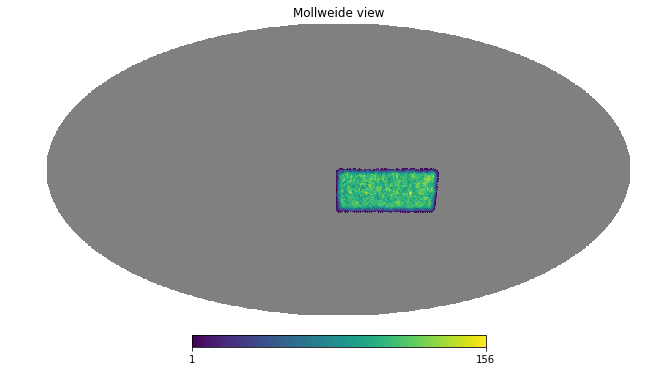

In [5]:
hp.mollview(bl[-2].metricValues)

In [6]:
dbFile = 'minion_1016_sqlite.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
bl = survey_perf(conn, mjdCol='expMJD', latCol = 'fieldDec', lonCol = 'fieldRA',
                 expTimeCol='visitExpTime', degrees=False,
                outDir='minion_1016', runName='minion_1016')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database Summary with no constraint for columns ['visitExpTime', 'expMJD', 'altitude', 'azimuth'].
Found 2447931 visits
Running:  ['minion_1016_BruteOSFMetric_UNIS']
Completed metric generation.
Running:  ['minion_1016_Observation_Density_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with constraint fieldDec > -0.349066 and fieldDec < -0.017453 and fieldRA > 5.235988 and fieldRA < 6.283185 and filter="g" for columns ['airmass', 'fieldDec', 'expMJD', 'fieldRA']
Found 12445 visits
Running:  ['minion_1016_Median_airmass_fieldDec_gt_-0_349066_and_fieldDec_lt_-0_017453_and_fieldRA_gt_5_235988_and_fieldRA_lt_6_283185_and_g_UNIS', 'minion_1016_Count_expMJD_fieldDec_gt_-0_349066_and_fieldDec_lt_-0_017453_and_fieldRA_gt_5_235988_and_fieldRA_lt_6_283185_and_g_U

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Plotting complete.
Plotting figures with "fieldDec > -0.349066 and fieldDec < -0.017453 and fieldRA > 5.235988 and fieldRA < 6.283185 and filter="g"" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 809 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 45.4274  dipole: lon: -27.3871, lat: -16.2299, amp: 62.6184
Plotting complete.
Open Shutter Fraction=0.735663
Median airmass = 1.246743
Counts in sub area= 12445
Median Count = 88.000000
Median Count / N obs = 0.007071


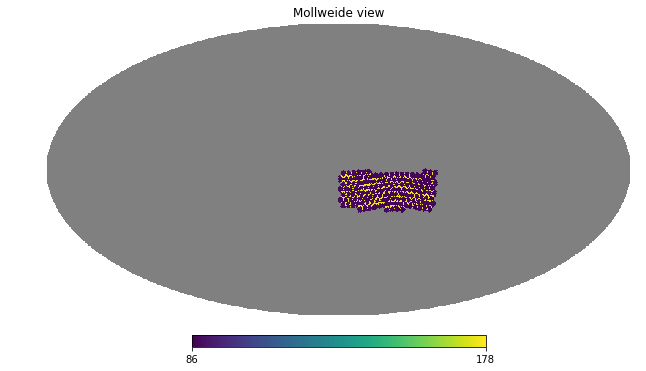

In [7]:
hp.mollview(bl[-2].metricValues)

In [8]:
dbFile = 'minion_1016_sqlite.db'
conn = db.OpsimDatabase(dbFile)
bl = survey_perf(conn, mjdCol='expMJD',latCol = 'ditheredDec', lonCol = 'ditheredRA',
                 expTimeCol='visitExpTime', degrees=False, outDir='minion_1016_dithered', runName='minion_1016_dithered')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database Summary with no constraint for columns ['visitExpTime', 'expMJD', 'altitude', 'azimuth'].
Found 2447931 visits
Running:  ['minion_1016_dithered_BruteOSFMetric_UNIS']
Completed metric generation.
Running:  ['minion_1016_dithered_Observation_Density_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with constraint ditheredDec > -0.349066 and ditheredDec < -0.017453 and ditheredRA > 5.235988 and ditheredRA < 6.283185 and filter="g" for columns ['airmass', 'ditheredDec', 'expMJD', 'ditheredRA']
Found 12579 visits
Running:  ['minion_1016_dithered_Median_airmass_ditheredDec_gt_-0_349066_and_ditheredDec_lt_-0_017453_and_ditheredRA_gt_5_235988_and_ditheredRA_lt_6_283185_and_g_UNIS', 'minion_1016_dithered_Count_expMJD_ditheredDec_gt_-0_349066_and_dithered

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Plotting complete.
Plotting figures with "ditheredDec > -0.349066 and ditheredDec < -0.017453 and ditheredRA > 5.235988 and ditheredRA < 6.283185 and filter="g"" constraint now.
monopole: -192.676  dipole: lon: -30.0677, lat: -11.4179, amp: 297.184
Plotting complete.
Open Shutter Fraction=0.735663
Median airmass = 1.247618
Counts in sub area= 12579
Median Count = 103.000000
Median Count / N obs = 0.008188


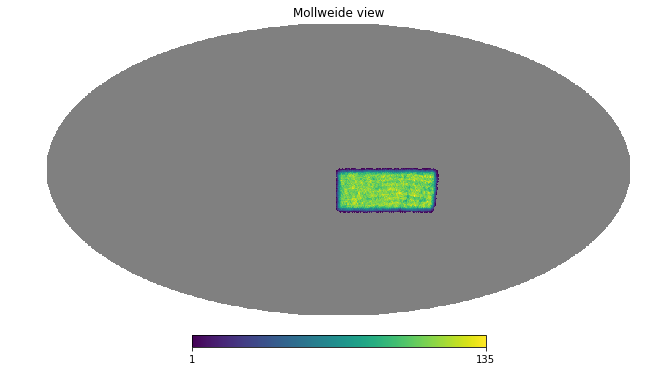

In [9]:
hp.mollview(bl[-2].metricValues)

In [10]:
dbFile = 'astro-lsst-01_2013.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
bl = survey_perf(conn, mjdCol='observationStartMJD',lonCol = 'fieldRA', latCol = 'fieldDec',
                 expTimeCol='visitExposureTime', degrees=True, outDir='astro-lsst-01_2013',
                 runName='astro-lsst-01_2013')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['azimuth', 'altitude', 'visitExposureTime', 'observationStartMJD'].
Found 2364554 visits
Running:  ['astro-lsst-01_2013_BruteOSFMetric_UNIS']
Completed metric generation.
Running:  ['astro-lsst-01_2013_Observation_Density_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint fieldDec > -20.000000 and fieldDec < -1.000000 and fieldRA > 300.000000 and fieldRA < 360.000000 and filter="g" for columns ['airmass', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 11789 visits
Running:  ['astro-lsst-01_2013_Median_airmass_fieldDec_gt_-20_000000_and_fieldDec_lt_-1_000000_and_fieldRA_gt_300_000000_and_fieldRA_lt_360_000000_and_g_UNIS', 'astro-lsst-01_2013_Count_observationStartMJD_field

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Plotting complete.
Plotting figures with "fieldDec > -20.000000 and fieldDec < -1.000000 and fieldRA > 300.000000 and fieldRA < 360.000000 and filter="g"" constraint now.
monopole: 54.1662  dipole: lon: -37.6369, lat: -19.6389, amp: 48.0862
Plotting complete.
Open Shutter Fraction=0.715178
Median airmass = 1.076681
Counts in sub area= 11789
Median Count = 84.000000
Median Count / N obs = 0.007125


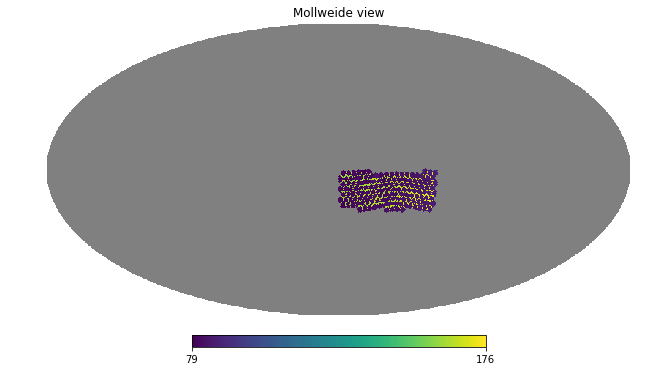

In [11]:
hp.mollview(bl[-2].metricValues)

In [12]:
#OK what are the lessons we can learn from here? (run with r-filter)
#
#Run      airmass    OSF     dithered?
#
#FB        1.10     0.705    yes
#Minion    1.22     0.736    no
#lsst-2013 1.08     0.715    no

# Dithering boosted Minion from 199 to 236 median observations. 
# r-band has extinction coef of 0.1.

# So, the max would be OSF=1, airmass=1, and dithered.  
# If dithered, 1, else 0.84
# Total median throughput = OSF *(exp(-.092*X))*dither factor
# If we did g instead, c = -0.369


In [13]:
# Total throughput in r.
# FB, Minion, lsst-2013
c=-0.092
np.exp(c*1.1)*.705, np.exp(c*1.22)*.736*.84, np.exp(c*1.08)*0.715*.84

(0.63714534637150333, 0.55260128153326271, 0.5437932696198472)

In [14]:
# Wow, so I didn't expect that! For total throughput (in r), minion is better than lsst-2013. 
#The decreased airmass throughput is offset by the increase in oppen shutter fraction.

In [15]:
# ok, now looking at g-band
#Run      airmass    OSF     dithered?
#
#FB        1.10     0.705    yes
#Minion    1.25     0.736    no
#lsst-2013 1.08     0.715    no


In [16]:
# Total throughput in r.
# FB, Minion, lsst-2013
c = -0.369
np.exp(c*1.1)*.705, np.exp(c*1.22)*.736*.85, np.exp(c*1.08)*0.715*.85

(0.46979564525016992, 0.39882837608547855, 0.40799038714041064)

In [17]:
# Now in the blue, the airmass penalty is larger, so lsst-2013 wins by a hair over minion.
# In both, the dithering makes the FB way better for a median point in the WFD region.

In [18]:
0.637/0.552*10

11.539855072463768

In [19]:
10.*0.47/0.41

11.463414634146341

In [20]:
# In both cases, it would take an extra 1.5 years for the proposal scheduler to get the throughput FB does in 10.